In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path
import json
import gc
import h5py
import dask.array as da

I believe we need to do something along the lines of taking the information from the scans as an array and feed that into our model to try predict the final volumetric meshes.
Here I convert from .RAW to .npy for faster compute. Use /processed_scans

In [3]:
file_path = "../../volumes/scan_005.raw"
raw_img = np.fromfile(file_path, dtype=np.dtype('<u2'))
img_arr = np.array(raw_img)
img_arr

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

In [4]:
def save_progress(processed_files, output_file='processed_scans.json'):
    """Save list of processed files"""
    with open(output_file, 'w') as f:
        json.dump(processed_files, f)

def load_progress(output_file='processed_scans.json'):
    """Load list of previously processed files"""
    try:
        with open(output_file, 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        return []

def process_scans_in_batches(folder_path="../../volumes/", 
                            batch_size=5,
                            output_dir="processed_scans/",
                            start_from_scratch=False):
    """
    Process scans in smaller batches and save each scan separately
    
    Parameters:
    folder_path: str, path to folder containing .raw files
    batch_size: int, number of scans to process at once
    output_dir: str, where to save processed scans
    start_from_scratch: bool, whether to restart processing from beginning
    """
    # Create output directory if it doesn't exist
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Get list of processed files if not starting from scratch
    processed_files = [] if start_from_scratch else load_progress()
    print(f"Already processed {len(processed_files)} files")
    
    # Get all .raw files
    folder = Path(folder_path)
    raw_files = sorted(folder.glob("*.raw"))
    
    # Filter out already processed files
    remaining_files = [f for f in raw_files if f.name not in processed_files]
    print(f"Found {len(remaining_files)} files to process")
    
    # Process in batches
    for i in range(0, len(remaining_files), batch_size):
        batch_files = remaining_files[i:i+batch_size]
        print(f"\nProcessing batch {i//batch_size + 1}/{len(remaining_files)//batch_size + 1}")
        
        for file_path in batch_files:
            try:
                print(f"Processing {file_path.name}...")
                
                # Load and reshape scan
                raw_img = np.fromfile(file_path, dtype=np.dtype('<u2'))
                scan_3d = np.reshape(np.array(raw_img), (1280, 768, 768)).astype(np.float32)
                
                # Save the processed scan
                output_file = output_path / f"{file_path.stem}.npy"
                np.save(output_file, scan_3d)
                
                # Update progress
                processed_files.append(file_path.name)
                save_progress(processed_files)
                
                # Clean up memory
                del raw_img, scan_3d
                gc.collect()
                
            except Exception as e:
                print(f"Error processing {file_path.name}: {str(e)}")
                continue
        
        # Additional memory cleanup after each batch
        gc.collect()
    
    return processed_files

def load_processed_scan(scan_name, processed_dir="processed_scans/"):
    """Load a single processed scan"""
    scan_path = Path(processed_dir) / f"{Path(scan_name).stem}.npy"
    return np.load(scan_path)

def load_all_processed_scans_in_batches(processed_dir="processed_scans/", batch_size=5):
    """Load all processed scans in batches and return as a single numpy array"""
    processed_path = Path(processed_dir)
    processed_files = sorted(processed_path.glob("*.npy"))
    
    all_scans_list = []
    for i in range(0, len(processed_files), batch_size):
        batch_files = processed_files[i:i+batch_size]
        batch_scans = [np.load(scan_file) for scan_file in batch_files]
        
        # Append the batch to the list of all scans
        all_scans_list.extend(batch_scans)
        
        # Memory cleanup after each batch
        gc.collect()
    
    # Stack all scans along a new axis
    all_scans_array = np.stack(all_scans_list, axis=0)
    return all_scans_array

These scans are stored in /processed_scans and not on the repo, but should be on our shared instance. These .npy files will load MUCH faster than the .RAW files.

In [5]:
processed_files = process_scans_in_batches(
    folder_path="../../volumes/",
    batch_size=5,  # adjust based on your memory
    output_dir="processed_scans/"
)

Already processed 87 files
Found 0 files to process


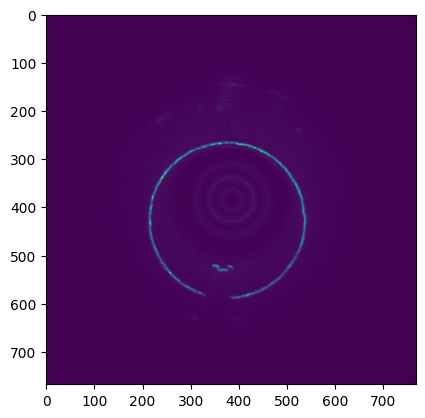

In [6]:
scan = load_processed_scan("scan_005", "processed_scans/")
plt.imshow(np.squeeze(scan[640, :, :])/65535)
plt.show()

In [7]:
# all_scans = load_all_processed_scans_in_batches()
# all_scans

In [1]:
#saves all npy's to a h5 file which cuts down the file size, but its still pretty useless since its still too big 
#ignore
def npy_to_hdf5_individual(directory, output_file="processed_scans.h5", chunk_size="auto"):
    with h5py.File(output_file, 'w') as hdf:
        for i, file in enumerate(os.listdir(directory)):
            if file.endswith(".npy"):
                file_path = os.path.join(directory, file)
                
                # Load each file as a Dask array with memory-mapping
                npy_array = da.from_array(np.load(file_path, mmap_mode='r'), chunks=chunk_size)

                # Create a dataset for each file in the HDF5 file with gzip compression
                dset = hdf.create_dataset(file, shape=npy_array.shape, dtype=npy_array.dtype, compression="gzip")
                
                # Write data in chunks from Dask array to HDF5 dataset
                for chunk in da.core.slices_from_chunks(npy_array.chunks):
                    dset[chunk] = npy_array[chunk].compute()  # Compute each chunk before saving
                    
                print(f"Processed and saved: {file}")

    print("All files processed and saved individually to HDF5.")

# Usage
directory_path = "/home/sid/DeepView/team_aase/code/processed_scans"
npy_to_hdf5_individual(directory_path)


NameError: name 'h5py' is not defined